In [4]:
import numpy as np
import geopandas as gpd

from explore import *
from utils import *
from graphic import *

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns; sns.set()

import contextily as cx

import warnings
warnings.filterwarnings('ignore')

# dados de https://appeears.earthdatacloud.nasa.gov

In [2]:
df = read_burn_df()
df.drop(["pais", "estado", "municipio", "bioma", "diasemchuva", "precipitacao", "riscofogo", "frp"], axis=1, inplace=True)
df = df[(df["simp_satelite"] != "ATSR") & (df["simp_satelite"] != "TRMM")]

pais_folder = os.path.join(aux_folder, "ibge/BR_Pais_2021")

wrs2: gpd.GeoDataFrame = gpd.read_file('aux/grade_tm_am_do_sul', engine="pyogrio")
pais_shape: gpd.GeoDataFrame = gpd.read_file(pais_folder, engine="pyogrio")

join = gpd.sjoin(pais_shape, wrs2)
brasil_wrs2 = wrs2.iloc[join['index_right'].unique()]

In [3]:
# parametros escolhidos para a aplicação do AQ-FA
quadrat_width = 0.005
# burned_area_calc = BurnedAreaCalcPercentile()
min_area_percentage = 0.1
threshold_satellite = 2
years = np.arange(2010, 2023, 1)
hour: str = "10:00:00-03:00"

In [32]:
import time
import glob
from multiprocessing import Pool

files = [
    # ('linear_2-5_15', lambda: linear_burned_area_calc(2.5, 15)),
    # ('exponential_2-5_15_2', lambda: polinomial_burned_area_calc(2.5, 15, 2)),
    # ('exponential_2-5_15_3', lambda: polinomial_burned_area_calc(2.5, 15, 3)),
    ('percentile_1', lambda: BurnedAreaCalcPercentile(exponent=1))
]

def validate(args) -> dict:
    aq30m_file, quadrat_width, index = args
    aq30m_file, quadrat_width = str(aq30m_file), float(quadrat_width)
    print(index, aq30m_file)
    path, row, start, end = get_infos_from_aq30m(aq30m_file, hour=hour)
    burned_area_calc = files[int(index)][1]()    
    region = get_landsat_geometry(path, row)
    aqm_gdf, aqm_normalized_gdf = read_file_normalized_cached(path, row, aq30m_file, quadrat_width)

    explore_df = sub_space_by_landsat(df.query(f"'{start}' < datahora < '{end}'"), path, row)
    explorer = SatellitesExplore(explore_df, 
                                 delimited_region=region,
                                 quadrat_width=quadrat_width, 
                                 burned_area_calc=burned_area_calc,
                                 min_area_percentage=min_area_percentage,
                                 threshold_satellite=threshold_satellite)
    burned = explorer.get_burned_areas()

    model_area_km2 = burned['burned_are'].sum() / 1000000
    temp = gpd.GeoDataFrame({ 'value': burned['burned_fac'], 'geometry': burned['geometry'] }, crs=burned.crs)
    d = evaluate_gpd(aqm_normalized_gdf, temp)
    d['start_dt'] = start
    d['end_dt'] = end
    d['reference_area_km2'] = aqm_gdf['km2'].sum()
    d['model_area_km2'] = model_area_km2
    d['orbita_ponto'] = f"{path:03d}/{row:03d}"
    return d

for index, file in enumerate(files): 
    dt = pd.DataFrame({ 'aqm30_file': glob.glob("aq30m/*.zip") })
    items = [np.append(np.append(dt.iloc[i].values, quadrat_width), index) for i in range(len(dt))]
    with Pool(4) as pool:
        values = pool.map(validate, items, chunksize=1)
        dt = pd.concat([dt, pd.DataFrame(values)], axis=1)
        dt.to_csv(f'results/validate_results_{files[index][0]}.csv')


0000  aq30m/LS8_AQM_222_067_20190923_0107.zip  aq30m/LS8_AQM_220_074_20200927_0114.zip
aq30m/LS8_AQM_226_071_20191005_0111.zip
aq30m/LS8_AQM_221_073_20200918_0113.zip

0 aq30m/LS8_AQM_220_065_20170919_0105.zip
0 aq30m/LS8_AQM_224_069_20210910_0109.zip
0 aq30m/LS8_AQM_221_073_20210921_0113.zip
0 aq30m/LS8_AQM_221_067_20210719_0107.zip
0 aq30m/LS8_AQM_220_065_20210829_0105.zip
0 aq30m/LS8_AQM_221_070_20190916_0110.zip
0 aq30m/LS8_AQM_221_067_20190916_0107.zip
0 aq30m/LS8_AQM_226_071_20170913_0111.zip
0 aq30m/LS8_AQM_225_069_20180909_0109.zip
0 aq30m/LS8_AQM_221_067_20210820_0107.zip
0 aq30m/LS8_AQM_222_067_20160914_0107.zip
0 aq30m/LS8_AQM_221_070_20191018_0110.zip
0 aq30m/LS8_AQM_220_074_20160815_0114.zip
0 aq30m/LS8_AQM_222_074_20201011_0114.zip
0 aq30m/LS8_AQM_221_070_20170910_0110.zip
0 aq30m/LS8_AQM_221_067_20210804_0107.zip


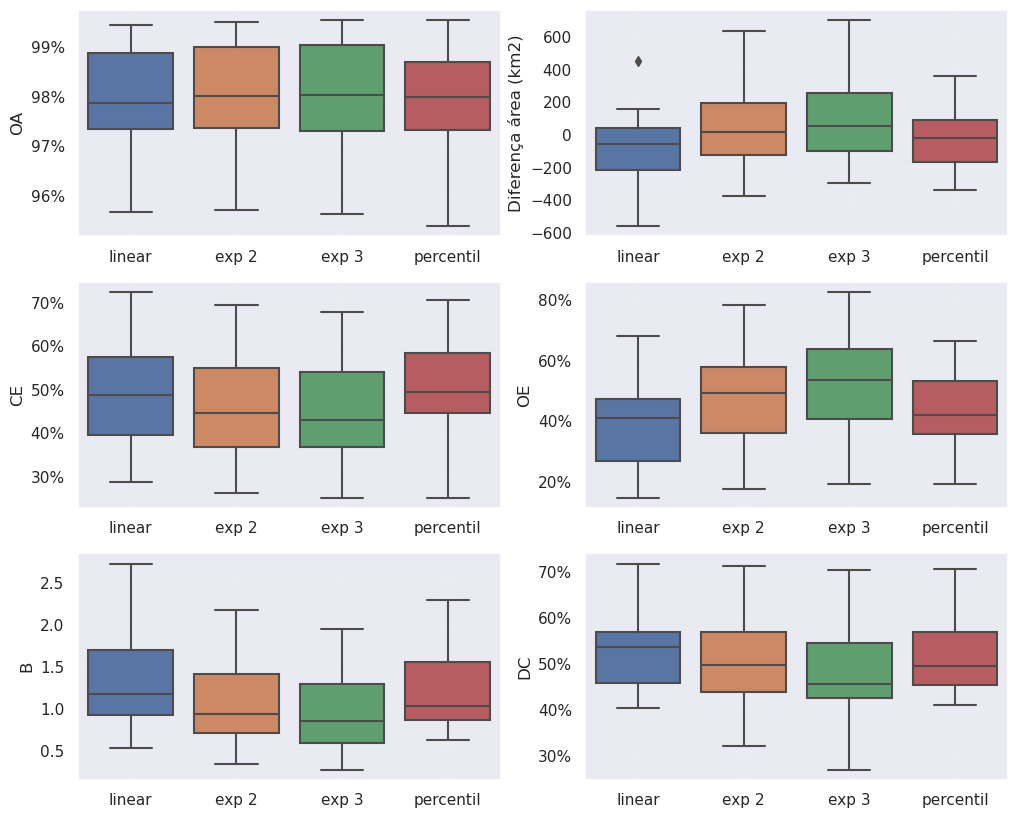

In [33]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs: list[plt.Axes] = axs.flat

files = [
    'results/validate_results_linear_2-5_15.csv',
    'results/validate_results_exponential_2-5_15_2.csv',
    'results/validate_results_exponential_2-5_15_3.csv',
    'results/validate_results_percentile_1.csv'
]

names = ['linear', 'exp 2', 'exp 3', 'percentil']

def read_set(file: str, name: str):
    data_set = pd.read_csv(file)
    data_set['eval'] = name
    data_set['Diferença área (km2)'] = data_set['reference_area_km2'] - data_set['model_area_km2']
    return data_set

data_sets = pd.concat([read_set(file, name) for (file, name) in zip(files, names)], ignore_index=True)
data_sets['OA'] = data_sets['ACC']

columns = ['OA', 'Diferença área (km2)', 'CE', 'OE', 'B', 'DC']

for i, gcolumns in enumerate(columns):
    sns.boxplot(ax=axs[i], data=data_sets, y=gcolumns, x="eval", orient='v', )
    if gcolumns in ['OA', 'CE', 'OE', 'DC']:
        axs[i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    axs[i].set(xlabel=None)
    axs[i].yaxis.grid(True, linewidth=0.075) # Hide the horizontal gridlines
    axs[i].xaxis.grid(True, linewidth=0.075) #

fig.savefig(os.path.join(image_folder, 'comparacao_evals.pdf'), bbox_inches="tight")

In [34]:
temp = pd.read_csv("results/validate_results_percentile_1.csv")
columns = ['orbita_ponto', 'start_dt', 'end_dt', 'ACC', 'CSI', 'CE', 'OE', 'B', 'DC', 'reference_area_km2', 'model_area_km2']
print('\n'.join(to_pretty_table_latex(temp, columns, ["DC"]).values))

\multirow{2}{*}{1} & \multirow{2}{*}{221/070} & 25/08/2017 & 98.44\% & 30.62\% & 1.04 & $697.9Km^2$ \\
                         &  & 10/09/2017 & 0.55 & 28.15\% & 70.58\% & $722.7Km^2$ \\
\hline
\multirow{2}{*}{2} & \multirow{2}{*}{221/070} & 31/08/2019 & 97.89\% & 31.37\% & 0.96 & $882.2Km^2$ \\
                         &  & 16/09/2019 & 0.51 & 33.78\% & 67.39\% & $849.8Km^2$ \\
\hline
\multirow{2}{*}{3} & \multirow{2}{*}{224/069} & 25/08/2021 & 97.31\% & 25.10\% & 0.78 & $1181.4Km^2$ \\
                         &  & 10/09/2021 & 0.49 & 41.84\% & 65.47\% & $917.9Km^2$ \\
\hline
\multirow{2}{*}{4} & \multirow{2}{*}{225/069} & 24/08/2018 & 99.52\% & 54.18\% & 1.76 & $111.1Km^2$ \\
                         &  & 09/09/2018 & 0.41 & 19.31\% & 58.44\% & $195.4Km^2$ \\
\hline
\multirow{2}{*}{5} & \multirow{2}{*}{220/074} & 11/09/2020 & 97.20\% & 51.36\% & 1.49 & $699.0Km^2$ \\
                         &  & 27/09/2020 & 0.41 & 27.51\% & 58.20\% & $1039.9Km^2$ \\
\hline
\multirow{2}{*}{6} & \m

In [32]:
from multiprocessing import Pool

argss = [[brasil_wrs2.loc[index]['ORBITA'], brasil_wrs2.loc[index]['PONTO'], 
          f'{start} 00:00:00-03:00', f'{end} 23:59:59-03:00', year] 
          for year in years
          for index in brasil_wrs2.T
          for (start, end) in get_year_date_pairs(year)]

def calculate(args) -> float:
    path, row, start, end, year = args
    path, row = int(path), int(row)
    file_name = f'''aq_fa_{year}/AQ-FA_{path}_{row}_{start.split(' ')[0]}_{end.split(' ')[0]}'''
    if os.path.exists(file_name): return 0.0
    try:
        explore_df = sub_space_by_landsat(df.query(f"'{start}' < datahora < '{end}'"), path, row)
        if len(explore_df) == 0:
            os.mkdir(file_name) # cria uma pasta vazia só pra marcar
            return 0.0
        region = get_landsat_geometry(path, row)
        explorer = SatellitesExplore(explore_df, 
                                     delimited_region=region,
                                     quadrat_width=quadrat_width, 
                                     burned_area_calc=BurnedAreaCalcPercentile(),
                                     min_area_percentage=min_area_percentage,
                                     threshold_satellite=threshold_satellite)
        burned = explorer.get_burned_areas()
        temp = burned[burned['value'] > 0]
        if len(temp) > 0:
            temp.to_file(file_name, engine="pyogrio")
        else:
            os.mkdir(file_name) # cria uma pasta vazia só pra marcar
        km2 = explorer.get_total_area_m_2() / 1000000
        del explore_df, explorer, region, burned
        return km2
    except KeyboardInterrupt as error:
        raise error
    except Exception as error:
        print(f"ERROR {path}/{row}", error)
        raise error

print("Computing", len(argss), "values...")
with Pool(4) as pool:
    pool.map(calculate, argss, chunksize=1)

Computing 27504 values...


In [7]:
import glob
from multiprocessing import Pool

def recompute_area(file):
    try:
        if len(os.listdir(file)) > 0:
            gdf: gpd.GeoDataFrame = gpd.read_file(file, engine="pyogrio")
            SatellitesExplore.recalcule_burned_area_static(BurnedAreaCalcPercentile(), gdf)
            gdf.to_file(file)
        return 0.0
    except KeyboardInterrupt as error:
        raise error
    except Exception as error:
        print(f"ERROR {file}", error)
        raise error
    
args = [file
        for year in years
        # for (start, end) in get_year_date_pairs(year)
        for file in glob.iglob(f'aq_fa/aq_fa_{year}/AQ-FA_*')]

with Pool(4) as pool:
    pool.map(recompute_area, args, chunksize=1)


In [8]:
import glob
from multiprocessing import Pool

aq1km = pd.read_csv('aq1km/area_queimada_aq1km.csv')
argss = [(start, end)
          for year in years
          for (start, end) in get_year_date_pairs(year)]

def compare(args):
    start, end = args
    year, month = start.split('-')[0:2]
    year, month = int(year), int(month)
    files = glob.iglob(f'aq_fa/aq_fa_{year}/AQ-FA_*_*_{start}_{end}')
    gdfs_raw = (gpd.read_file(file, engine="pyogrio") for file in files if len(os.listdir(file)) > 0)
    gdfs_area = (gdf['burned_are'].sum() for gdf in gdfs_raw)
    burned_aq1km = aq1km[(aq1km['Ano'] == year) & (aq1km['Mês'] == month)].iloc[0]['Total mensal']
    burned_aqfa = np.sum(gdfs_area) / 1000000
    return { 
        'Ano': year, 
        'Mês': month, 
        'AQ-FA': round(burned_aqfa), 
        'AQ1km': round(burned_aq1km)
    }

values = []
with Pool(5) as pool:
    values = pool.map(compare, argss, chunksize=1)

data_df = pd.DataFrame(values)
data_df = data_df.set_index(["Ano", "Mês"])
data_df.index = data_df.index.map(lambda x: datetime.date(x[0], x[1], 1))
data_df.to_csv("results/compare_aq1km-aqfa-month.csv")
data_df

AQ-FA  AQ1km
Ano  Mês               
2010 1       813   2092
     2       940   2042
     3       523   1396
     4       763   3910
     5      2712  11728
...          ...    ...
2022 8     78720  57966
     9    123121  70333
     10    91092  50085
     11    27041   8792
     12     8522   4398

[156 rows x 2 columns]

<Axes: xlabel='Tempo', ylabel='Área Queimada (KM²)'>

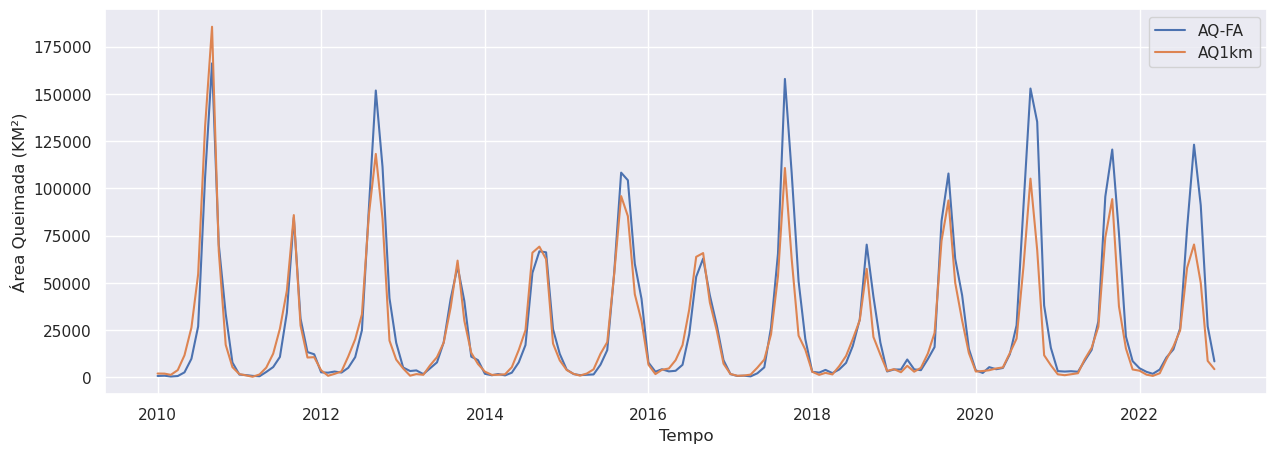

In [112]:
fig, ax = plt.subplots(figsize=(15, 5))
data_df.plot(ax=ax, xlabel="Tempo", ylabel="Área Queimada (KM²)")

In [35]:
def process_file(file: str, path: int = None, row: int = None):
    label = ''
    if file.startswith("aq1km"):
        start, end = get_infos_from_aq1km(file)
        label = "AQ1km"
        if path is None or row is None:
            raise ValueError("AQ1km without path or row")
    elif file.startswith("aq30m"):
        path, row, start, end = get_infos_from_aq30m(file, hour=hour)
        label = "AQ30m"
    else:
        raise ValueError(f"File unknown {file}")
    return (label, path, row, start, end)

def compare_matrix(gdf1: gpd.GeoDataFrame, gdf2: gpd.GeoDataFrame) -> tuple[np.ndarray, np.ndarray]:
    array1 = create_dataarray(gdf1, sparse=False)
    array2 = create_dataarray(gdf2, sparse=False)

    array1, array2 = xr.align(array1, array2, join='outer', fill_value=0.0)
    array1, array2 = array1.values, array2.values

    if array1.size == 0 or np.isnan(array1).all():
        array1 = np.zeros(np.shape(array2))
    if array2.size == 0 or np.isnan(array2).all():
        array2 = np.zeros(np.shape(array1))

    return (np.nan_to_num(array1), np.nan_to_num(array2))


def validate_plot(file: str, quadrat_width: float = 0.005, burned_area_calc=None, 
                  path: int = None, row: int = None, evaluate: bool = False, 
                  plot: bool = True):
    label, path, row, start, end = process_file(file=file, path=path, row=row)
    geometry = get_landsat_geometry(path, row)
    aq_gdf, aq_norm_gdf = read_file_normalized_cached(path, row, file, quadrat_width)
    explore_df = sub_space_by_landsat(df.query(f"'{start}' < datahora < '{end}'"), path, row)
    explorer = SatellitesExplore(explore_df, 
                                delimited_region=geometry,
                                quadrat_width=quadrat_width, 
                                burned_area_calc=BurnedAreaCalcPercentile(exponent=1) if burned_area_calc is None else burned_area_calc,
                                min_area_percentage=min_area_percentage,
                                threshold_satellite=threshold_satellite)
    xmin, ymin, xmax, ymax = geometry.bounds

    if plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), sharey=True, sharex=True)
        fig.tight_layout()

        aq_legend = 'km2' not in aq_gdf.columns
        plot_burned_gdf(ax1, aq_norm_gdf, legend=aq_legend, color_bar=False)
        configure_geografic_axes(ax1, xmin, xmax, ymin, ymax)
        cx.add_basemap(ax1, crs=aq_norm_gdf.crs.to_string())
        ax1.plot(*geometry.exterior.xy)
        ax1.set_title(label)
        if not aq_legend:
            ax1.legend(title = "{:.2f}Km²".format(aq_gdf['km2'].sum()), loc='lower left')

        explorer.show_satellites_quads_areas(ax=ax2, linewidth=0, cmap='Reds', with_color_bar=False)
        configure_geografic_axes(ax2, xmin, xmax, ymin, ymax)
        cx.add_basemap(ax2, crs=explorer.dataframe.crs.to_string())
        ax2.plot(*geometry.exterior.xy)
        ax2.set_title('AQ-FA')
        fig.savefig(os.path.join(image_folder, f'validacao_{label}_{path}_{row}.pdf'), bbox_inches="tight")

    burned = explorer.get_burned_areas()
    temp = gpd.GeoDataFrame({ 'value': burned['burned_fac'], 'geometry': burned['geometry'] }, crs=burned.crs)
    print(explorer.burned_area_calc)
    
    if evaluate:
        print(evaluate_gpd(aq_norm_gdf, temp))
    return (aq_norm_gdf, temp)

In [16]:
def two_validate_plot(ax1: plt.Axes, gpd1: gpd.GeoDataFrame, 
                      ax2: plt.Axes, gpd2: gpd.GeoDataFrame, geometry: Polygon):
    xmin, ymin, xmax, ymax = geometry.bounds
    plot_burned_gdf(ax1, gpd1, color_bar=False)
    configure_geografic_axes(ax1, xmin, xmax, ymin, ymax)
    cx.add_basemap(ax1, crs=gpd1.crs.to_string())
    ax1.plot(*geometry.exterior.xy)

    plot_burned_gdf(ax2, gpd2, color_bar=False)
    configure_geografic_axes(ax2, xmin, xmax, ymin, ymax)
    cx.add_basemap(ax2, crs=gpd2.crs.to_string())
    ax2.plot(*geometry.exterior.xy)

def plot_all(results: tuple[gpd.GeoDataFrame, gpd.GeoDataFrame]):
    size = len(results)
    fig, axs = plt.subplots(size, 2, figsize=(15, 8 * size))
    fig.tight_layout()
    axs = axs.flat
    for i in range(size):
        label, path, row, start, end = process_file(file=files[i])
        geometry = get_landsat_geometry(path, row)
        ax1, ax2 = axs[i*2], axs[i*2 + 1]
        two_validate_plot(ax1, results[i][0], ax2, results[i][1], geometry)
        ax1.set_title(f'{label} - {path}/{row} {start.split()[0]} {end.split()[0]}')
        ax2.set_title(f'AQ-FA - {path}/{row} {start.split()[0]} {end.split()[0]}')

In [36]:
files = glob.glob("aq30m/*")

results1 = []
for file in files:
    results1.append(validate_plot(file, plot=False, evaluate=False))

resolution = 0.1
normalized_array = [(normalize_gdf(ref, column='value', quadrat_width=resolution), 
                     normalize_gdf(test, column='value', quadrat_width=resolution)) 
                     for (ref, test) in results1]

# plot_all(normalized_array)
# plot_all(results1)

min_range: 7.427114977707966 max_range: 15
min_range: 7.184283948334672 max_range: 15
min_range: 5.596030057057614 max_range: 15
min_range: 3.4834487018979785 max_range: 9.356785110560171
min_range: 4.4130335337782665 max_range: 10.022656192922398
min_range: 8.75 max_range: 15
min_range: 7.3172072444669345 max_range: 15
min_range: 3.7706779378152646 max_range: 8.75
min_range: 5.609269867398485 max_range: 12.380419049422065
min_range: 8.75 max_range: 15
min_range: 6.11607984645347 max_range: 15
min_range: 6.034293093782104 max_range: 15
min_range: 8.75 max_range: 15
min_range: 5.089957092279303 max_range: 11.211796556999621
min_range: 4.358442289083056 max_range: 8.75
min_range: 5.410164551564419 max_range: 12.522564063317043
min_range: 2.5 max_range: 8.999437868545385
min_range: 5.641105851545625 max_range: 14.369362171849797
min_range: 8.75 max_range: 15
min_range: 4.626213560707382 max_range: 10.886824582745765


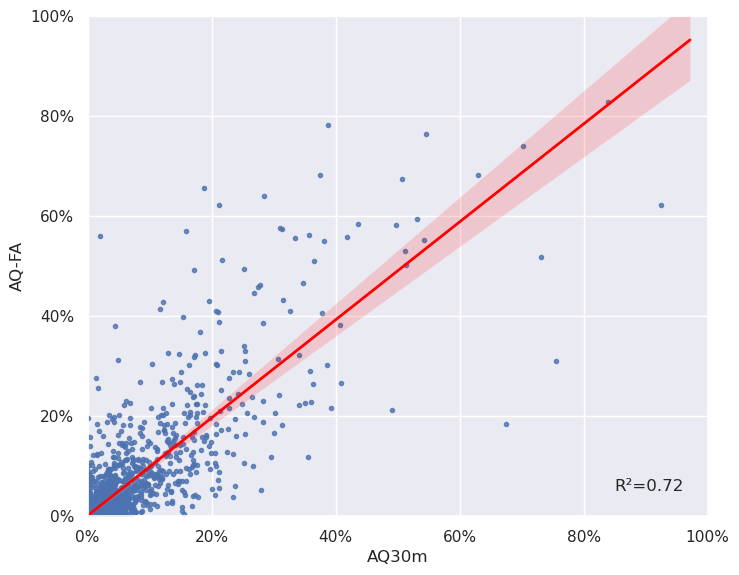

In [37]:
from itertools import chain
import scipy as sp

results_array = [compare_matrix(ref, test) for (ref, test) in normalized_array]

values1 = np.array(list(chain.from_iterable([value1.flatten() for (value1, _) in results_array])))
values2 = np.array(list(chain.from_iterable([value2.flatten() for (_, value2) in results_array])))

values1, values2 = values1.flatten(), values2.flatten()

fig, ax = plt.subplots(figsize = (8, 6.5))
sns.regplot(x=values1, y=values2, ax=ax, marker='.', truncate=False, line_kws={'lw': 2, 'color': 'red'})
ax.set_xlabel('AQ30m')
ax.set_ylabel('AQ-FA')
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.text(0.85, 0.05, 'R²={:.2f}'.format(sp.stats.pearsonr(values1, values2)[0] ** 2))
fig.savefig(os.path.join(image_folder, 'regressao_aq30m.pdf'), bbox_inches="tight")

In [ ]:
aq1km_file = 'aq1km/shp/2022_*_*_aq1km_V6.zip'
aqfa_file = 'aq_fa_2022/AQ-FA*2022*'
region = pais_shape.geometry[0]

gdf_aq1km = read_geopandas(aq1km_file, region=region)
gdf_aqfa = read_geopandas(aqfa_file)
resolution = get_quadrat_width(distance.distance(kilometers=10))

print("readed...")

gdf_aq1km = read_file_normalized(gdf_aq1km, file=aq1km_file, region=region, quadrat_width=resolution)
gdf_aqfa = read_file_normalized(gdf_aqfa, file=aqfa_file, quadrat_width=resolution, column='burned_are')

print("normalized...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), sharey=True, sharex=True)
fig.tight_layout()
xmin, ymin, xmax, ymax = region.bounds

plot_burned_gdf(ax1, gdf_aq1km, legend=False, color_bar=False)
configure_geografic_axes(ax1, xmin, xmax, ymin, ymax)
cx.add_basemap(ax1, crs=gdf_aq1km.crs.to_string())
ax1.set_title("AQ1km")

plot_burned_gdf(ax2, gdf_aqfa, legend=False, color_bar=False)
configure_geografic_axes(ax2, xmin, xmax, ymin, ymax)
cx.add_basemap(ax2, crs=gdf_aqfa.crs.to_string())
ax2.set_title("AQ-FA")

In [ ]:
from multiprocessing import Pool

year = 2022
resolution = 0.04 # get_quadrat_width(distance.distance(kilometers=10))
region = pais_shape.geometry[0]

aq1km_file = 'aq1km/shp/2022_*_*_aq1km_V6.zip'
aqfa_file = 'aq_fa_2022/AQ-FA*2022*'

gdf_aq1km = read_geopandas(aq1km_file, region=region)
gdf_aqfa = read_geopandas(aqfa_file)
gdf_aqfa.loc[gdf_aqfa['geometry'].duplicated(), 'burned_fac'] = 1
gdf_aqfa = gdf_aqfa.drop_duplicates(subset = 'geometry')

argss = [[brasil_wrs2.loc[index]['ORBITA'], brasil_wrs2.loc[index]['PONTO']] 
          for index in brasil_wrs2.T]

def calculate(args):
    path, row = args
    path, row = int(path), int(row)
    print(path, row)
    sub_aqfa = sub_space_by_landsat_geo(gdf_aqfa, path, row)
    sub_aqfa = normalize_gdf(sub_aqfa, column='burned_fac', quadrat_width=resolution)
    sub_aq1km = sub_space_by_landsat_geo(gdf_aq1km, path, row)
    sub_aq1km = normalize_gdf(sub_aq1km, quadrat_width=resolution)
    return compare_matrix(sub_aqfa, sub_aq1km)

print("Computing", len(argss), "values...")

# a,b = calculate([221, 70])

values = [calculate(args) for args in argss]
# with Pool(4) as pool:
#     values = pool.map(calculate, argss, chunksize=1)

aq1km/shp/2022_09_01_aq1km_V6.zip 2022-09-01 00:00:00-03:00 2022-09-30 23:59:59-03:00


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


HIT!


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


min_range: 5.225593746168151 max_range: 15
{'TP': 1112.8162219139838, 'FP': 752.13158018457, 'FN': 908.1837780882486, 'TN': 87152.86841981321, 'ACC': 0.9815368707796096, 'CE': 0.403298998147951, 'OE': 0.44937346763347125, 'B': 0.9227846620962364, 'DC': 0.5727386360220191, 'TPR': 0.5506265323665287, 'TNR': 0.9914438134328584, 'PPV': 0.5967010018520489, 'NPV': 0.9896868847757205, 'CSI': 0.4012850417429608}


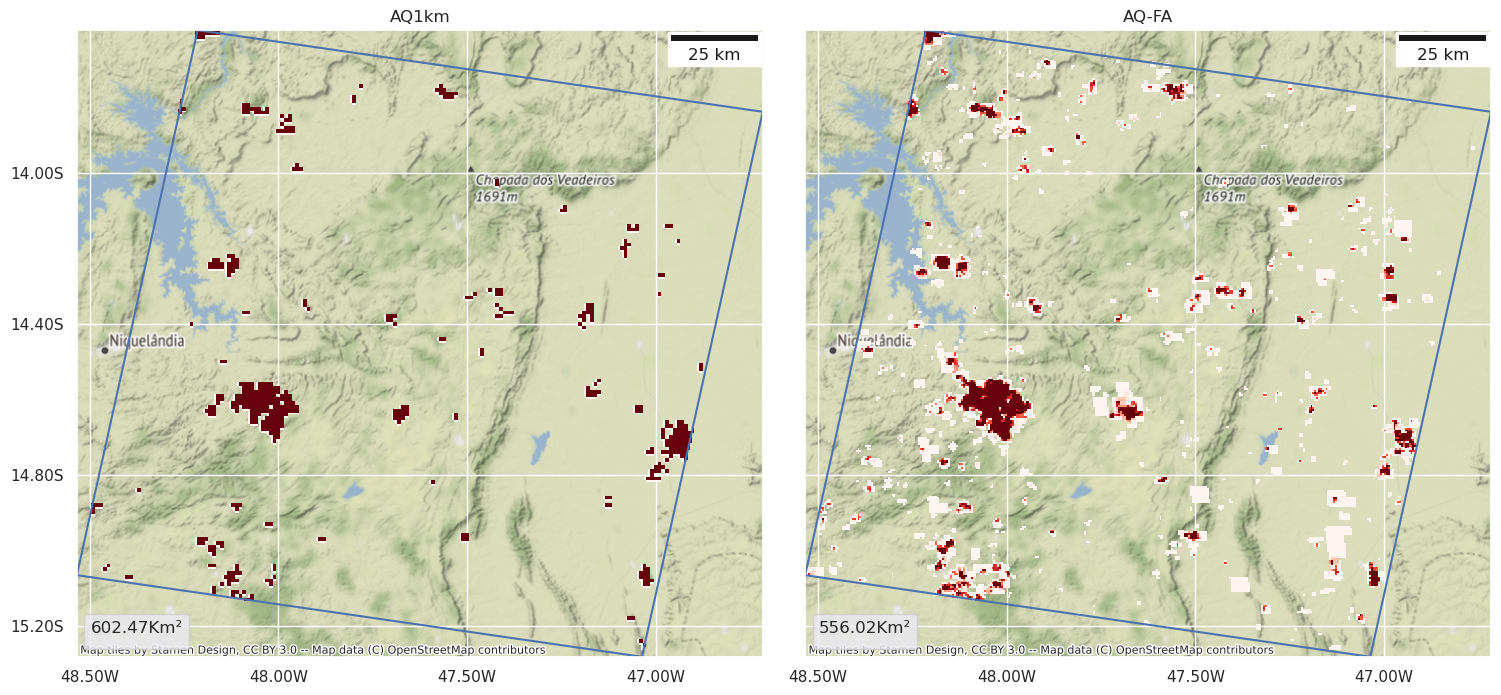

In [44]:
validate_plot(file='aq1km/shp/2022_09_01_aq1km_V6.zip', quadrat_width=0.005, path=221, row=70)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


min_range: 8.75 max_range: 15
{'TP': 1679.8829337088077, 'FP': 741.679214689799, 'FN': 658.3163226743104, 'TN': 86846.12152892709, 'ACC': 0.9844316934216566, 'CE': 0.306281304892495, 'OE': 0.2815484270115789, 'B': 1.0356526039378013, 'DC': 0.7058685471171615, 'TPR': 0.7184515729884211, 'TNR': 0.9915321630593191, 'PPV': 0.693718695107505, 'NPV': 0.9924767664493687, 'CSI': 0.5454380585100157}


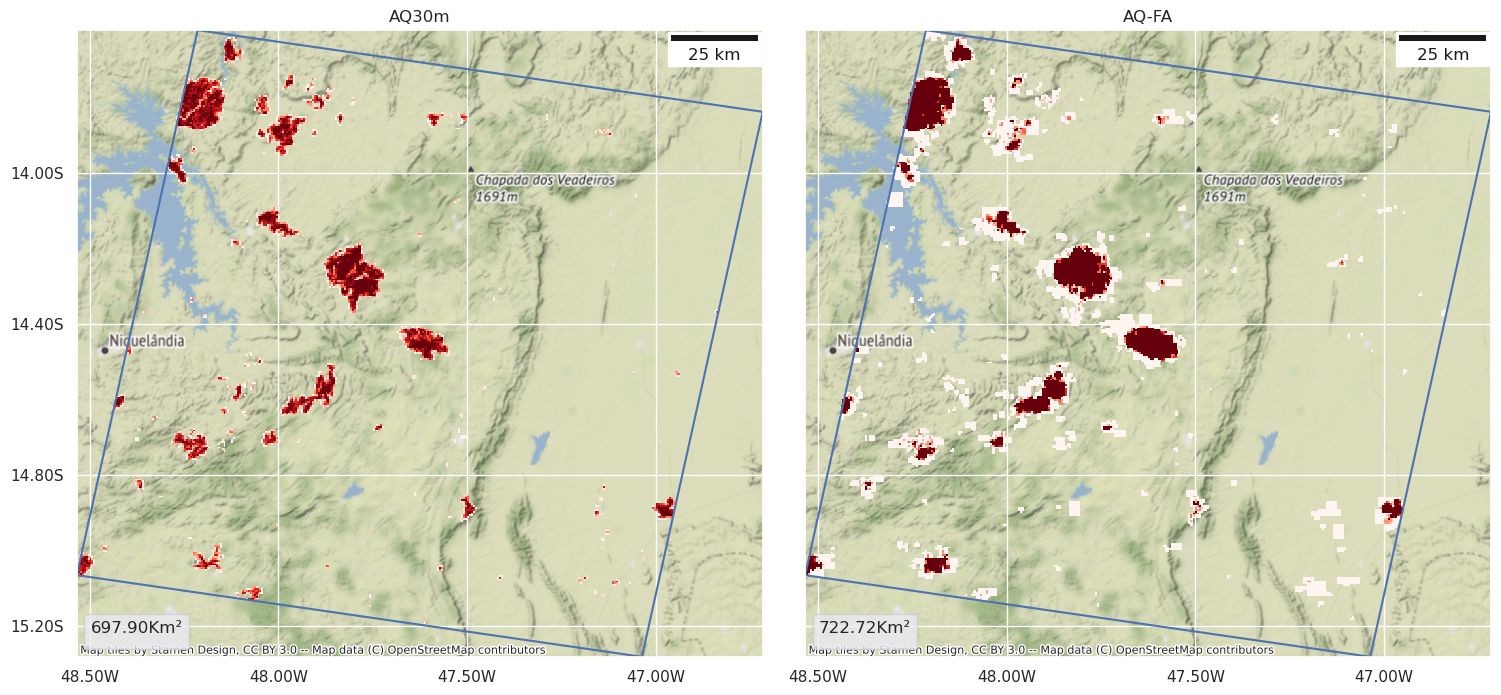

In [11]:
n = validate_plot(file='aq30m/LS8_AQM_221_070_20170910_0110.zip', quadrat_width=0.005, evaluate=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


min_range: 3.4834487018979785 max_range: 9.356785110560171
{'TP': 328.83072161653405, 'FP': 742.2450974428607, 'FN': 190.3091734915775, 'TN': 88576.61500744903, 'ACC': 0.9896196011605954, 'CE': 0.6929902479683381, 'OE': 0.3665855298058828, 'B': 2.06317377869089, 'DC': 0.4135674408030614, 'TPR': 0.6334144701941172, 'TNR': 0.9916899398786414, 'PPV': 0.30700975203166203, 'NPV': 0.9978560801193961, 'CSI': 0.26069021239226936}


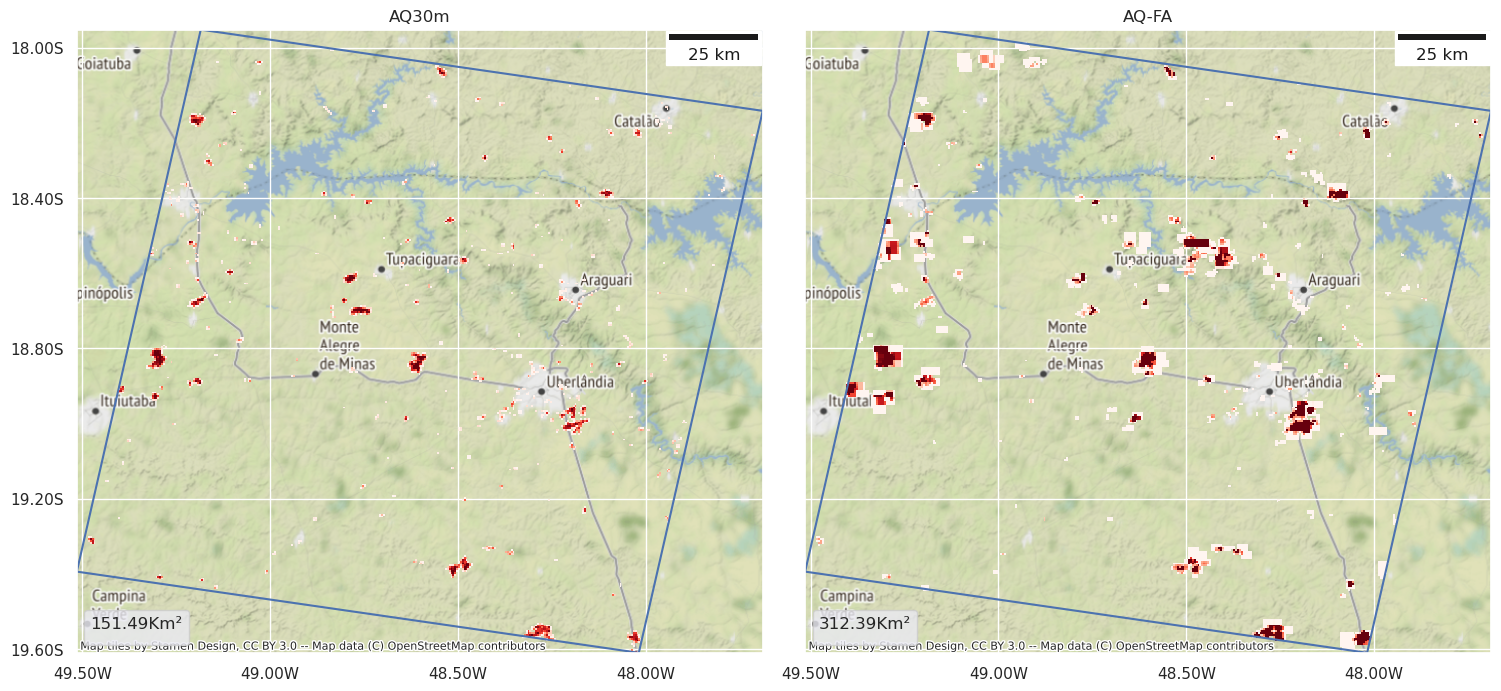

In [12]:
n = validate_plot(file='aq30m/LS8_AQM_221_073_20200918_0113.zip', quadrat_width=0.005, evaluate=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


min_range: 5.596030057057614 max_range: 15
{'TP': 429.12010568275036, 'FP': 421.2001007292227, 'FN': 383.6398345654145, 'TN': 88665.03995902262, 'ACC': 0.9910472871189376, 'CE': 0.49534292793831924, 'OE': 0.4720210920438272, 'B': 1.046213235057254, 'DC': 0.5160546309743713, 'TPR': 0.5279789079561729, 'TNR': 0.9952719959844897, 'PPV': 0.5046570720616809, 'NPV': 0.9956917964931689, 'CSI': 0.347758510350834}


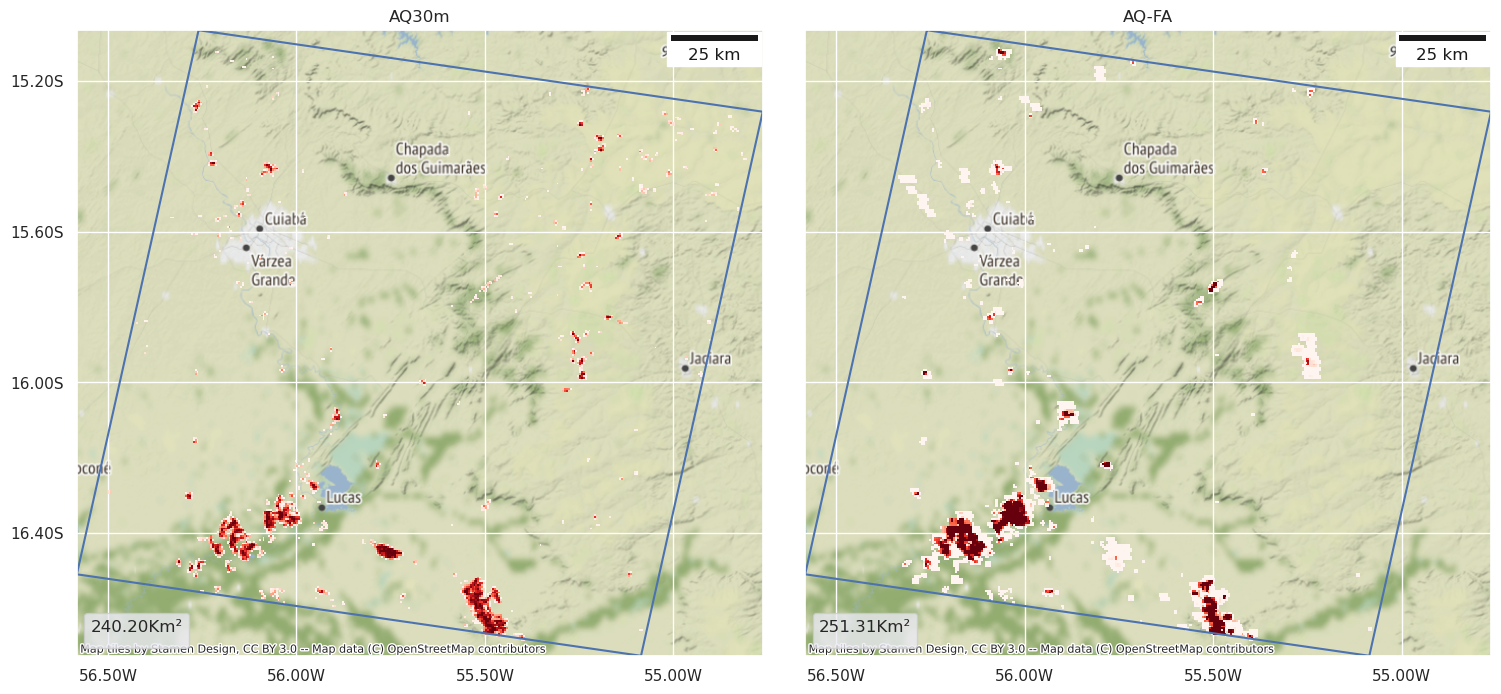

In [13]:
n = validate_plot(file='aq30m/LS8_AQM_226_071_20191005_0111.zip', quadrat_width=0.005, evaluate=True)

<class 'numpy.ndarray'>


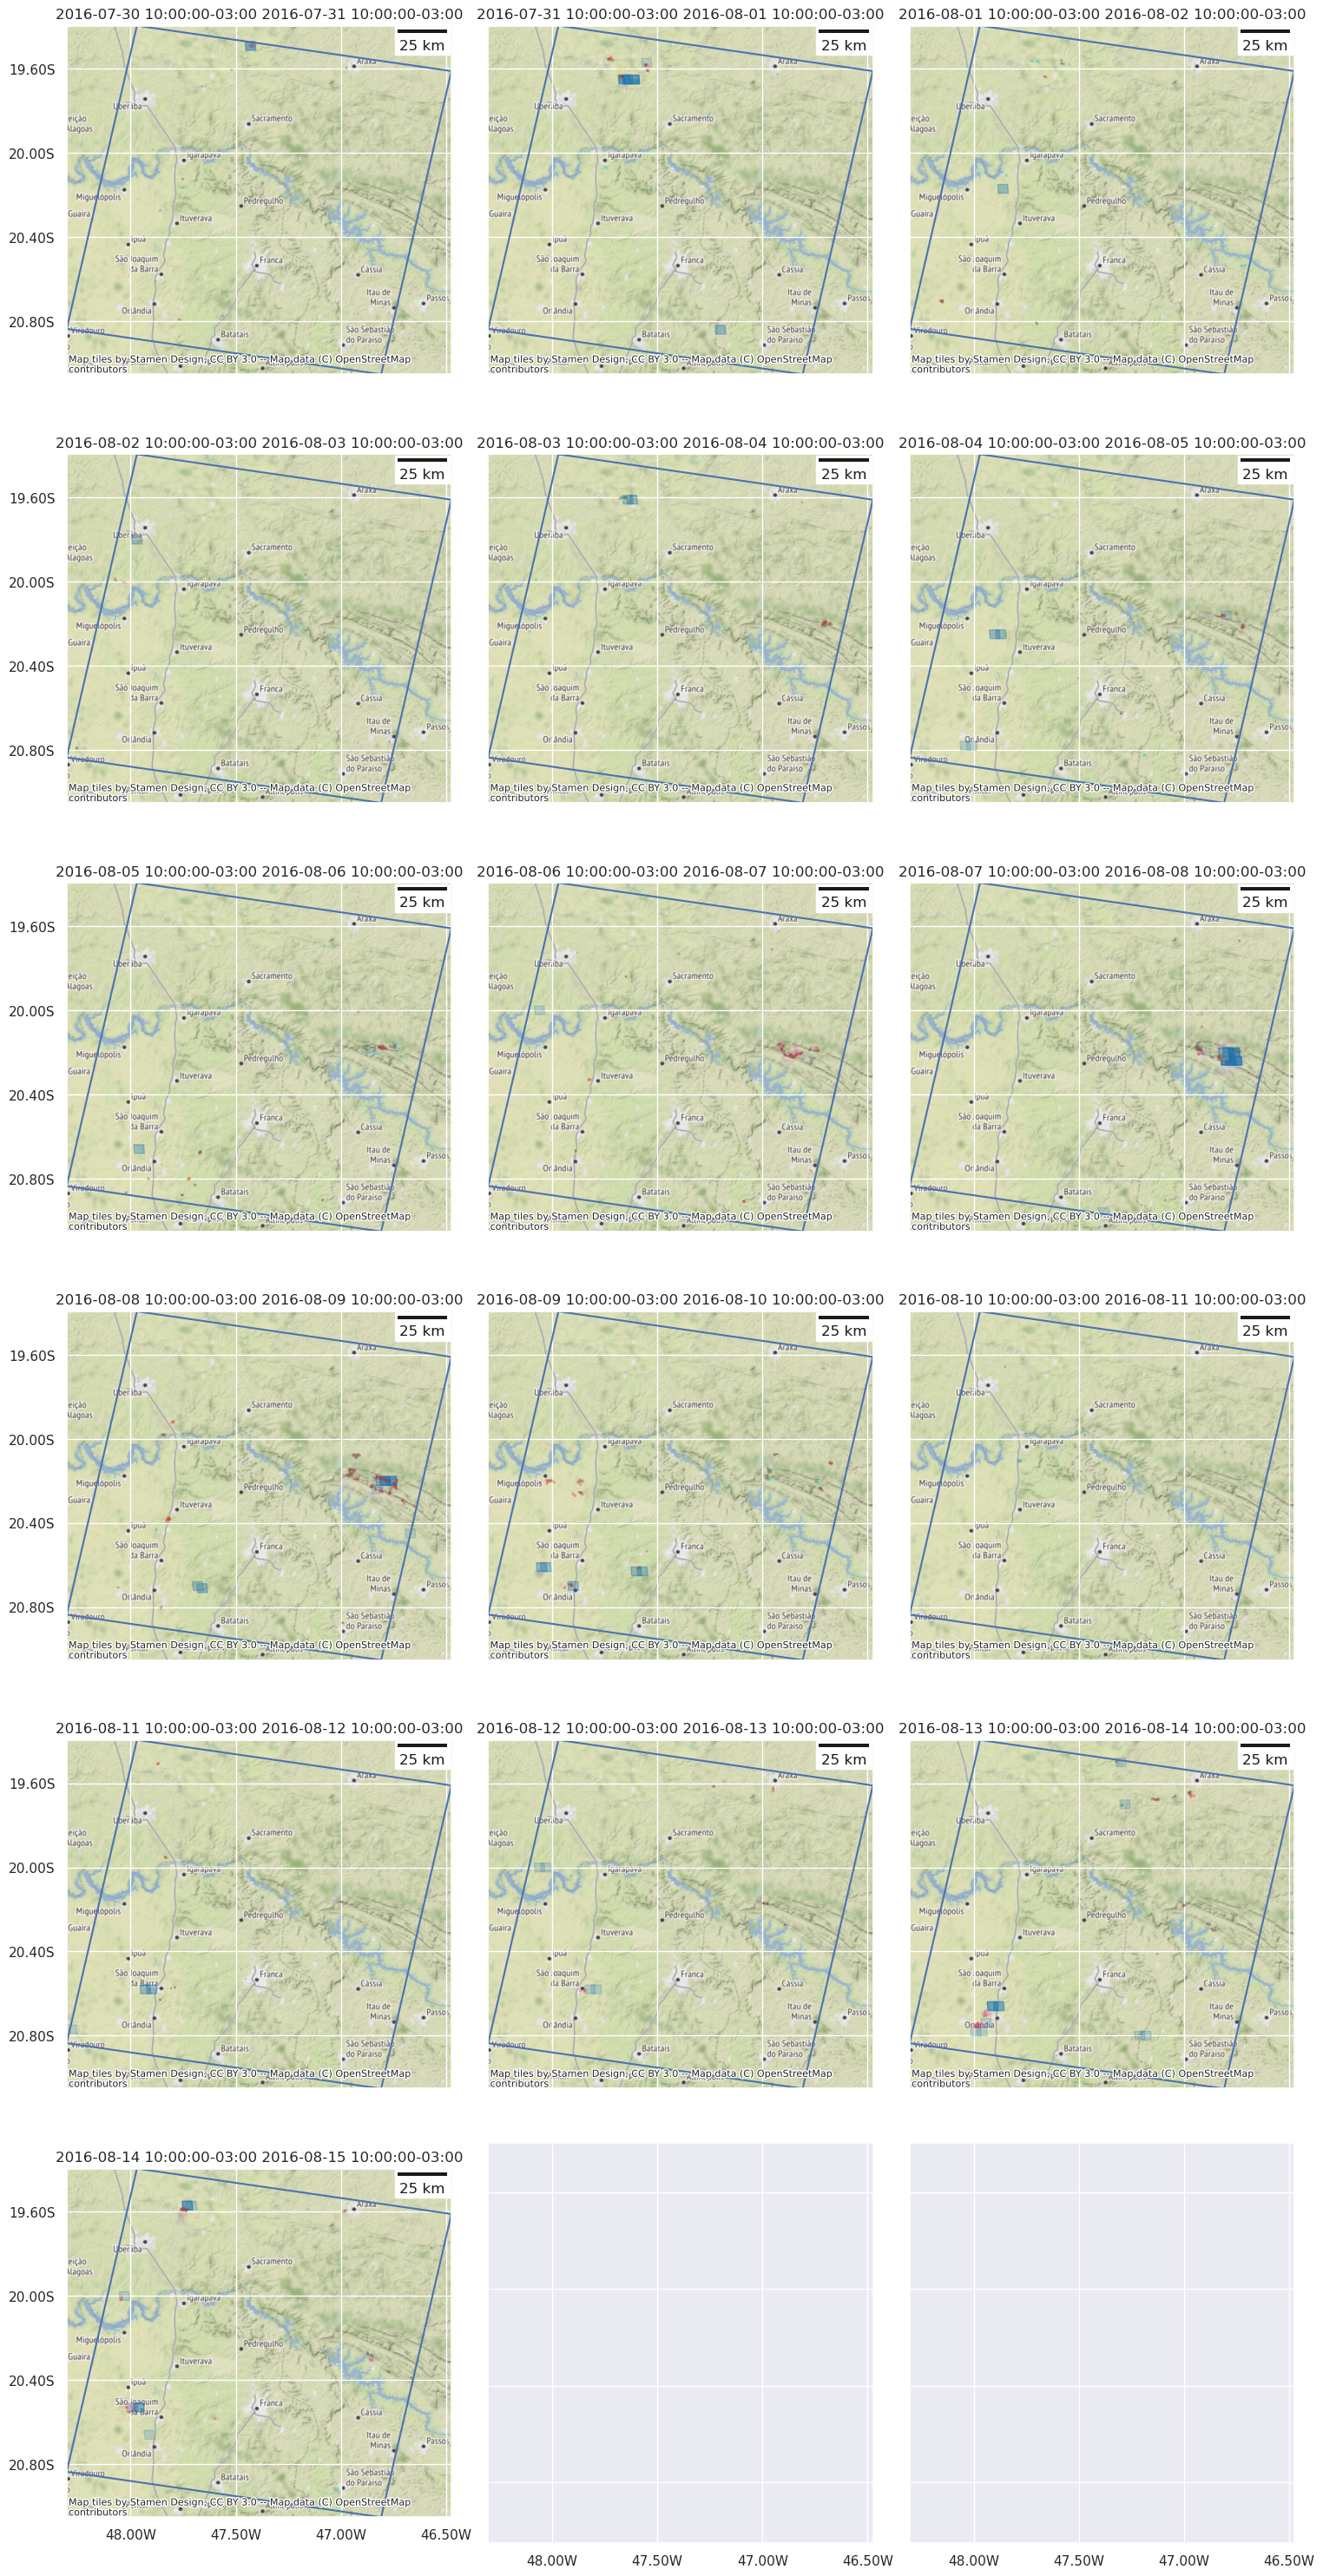

In [41]:
def show_daily_areas(file: str, path: int = None, row: int = None, freq='1D'):
    label, path, row, start, end = process_file(file=file, path=path, row=row)
    geometry = get_landsat_geometry(path, row)
    xmin, ymin, xmax, ymax = geometry.bounds
    date_range = pd.date_range(start, end, freq=freq)
    gcolumns = max(1, min(len(date_range) - 1, 3))
    grows = math.ceil((len(date_range) - 1) / gcolumns)
    gsize = 5
    fig, axs = plt.subplots(grows, gcolumns, figsize=(gsize * gcolumns, gsize * grows), sharey=True, sharex=True)
    axs = axs.flat if isinstance(axs, np.ndarray) else [axs]
    fig.tight_layout()
    for i, (start, end) in enumerate(split_by_range_index(date_range)):
        explore_df = sub_space_by_landsat(df.query(f"'{start}' < datahora < '{end}'"), path, row)
        explorer = SatellitesExplore(explore_df, delimited_region=geometry)
        explorer.show_satellites_areas(axs[i])
        axs[i].set_title(f'{start} {end}')
        configure_geografic_axes(axs[i], xmin, xmax, ymin, ymax)
        cx.add_basemap(axs[i], crs=explorer.dataframe.crs.to_string())
        axs[i].plot(*geometry.exterior.xy)

show_daily_areas(file='aq30m/LS8_AQM_220_074_20160815_0114.zip', freq='1D')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


min_range: 2.5 max_range: 8.999437868545385
{'TP': 627.9676962274574, 'FP': 947.6659862316765, 'FN': 384.52312258910865, 'TN': 87838.84319495177, 'ACC': 0.9851647667699998, 'CE': 0.6014507031562238, 'OE': 0.37977936732162415, 'B': 1.5561955260994749, 'DC': 0.4852685378295587, 'TPR': 0.6202206326783758, 'TNR': 0.9893264641782705, 'PPV': 0.39854929684377605, 'NPV': 0.9956414820853118, 'CSI': 0.3203660516394259}


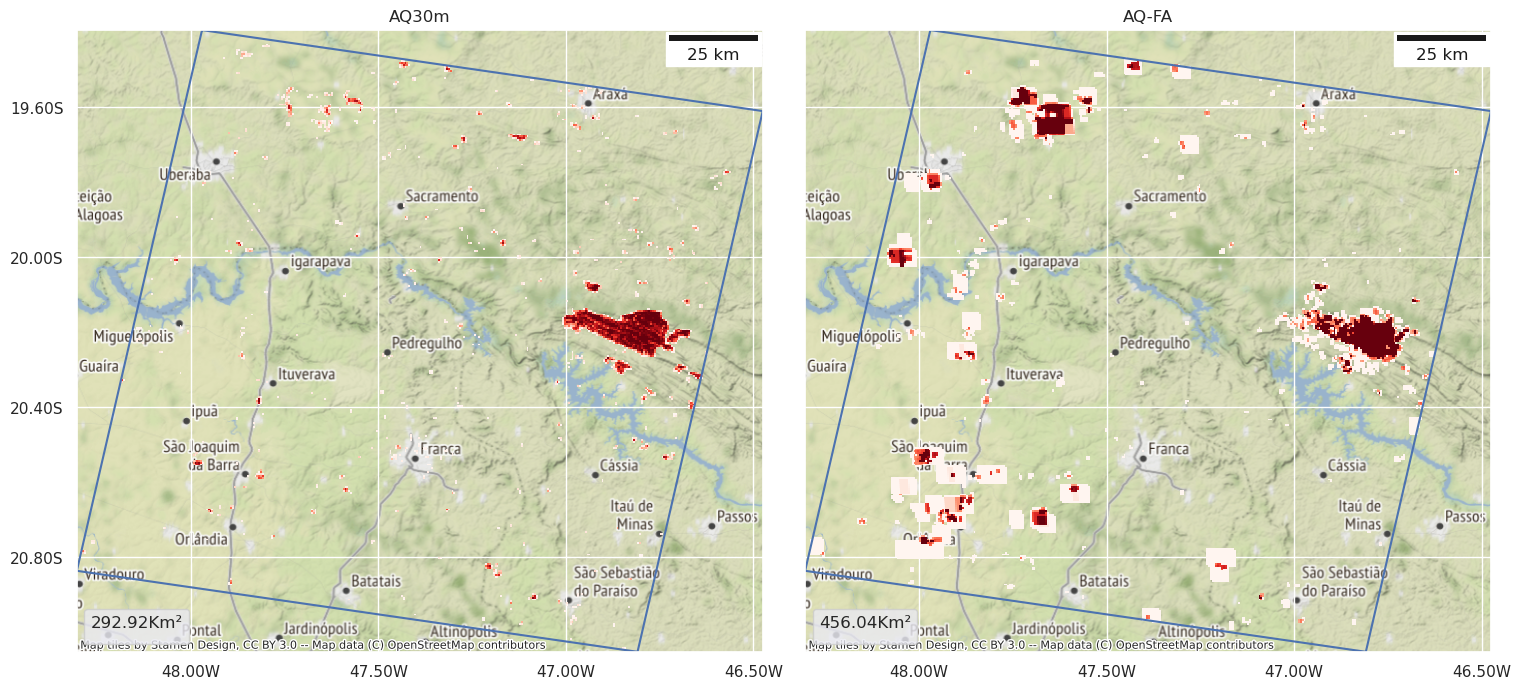

In [42]:
n = validate_plot(file='aq30m/LS8_AQM_220_074_20160815_0114.zip', quadrat_width=0.005, evaluate=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


min_range: 8.75 max_range: 15


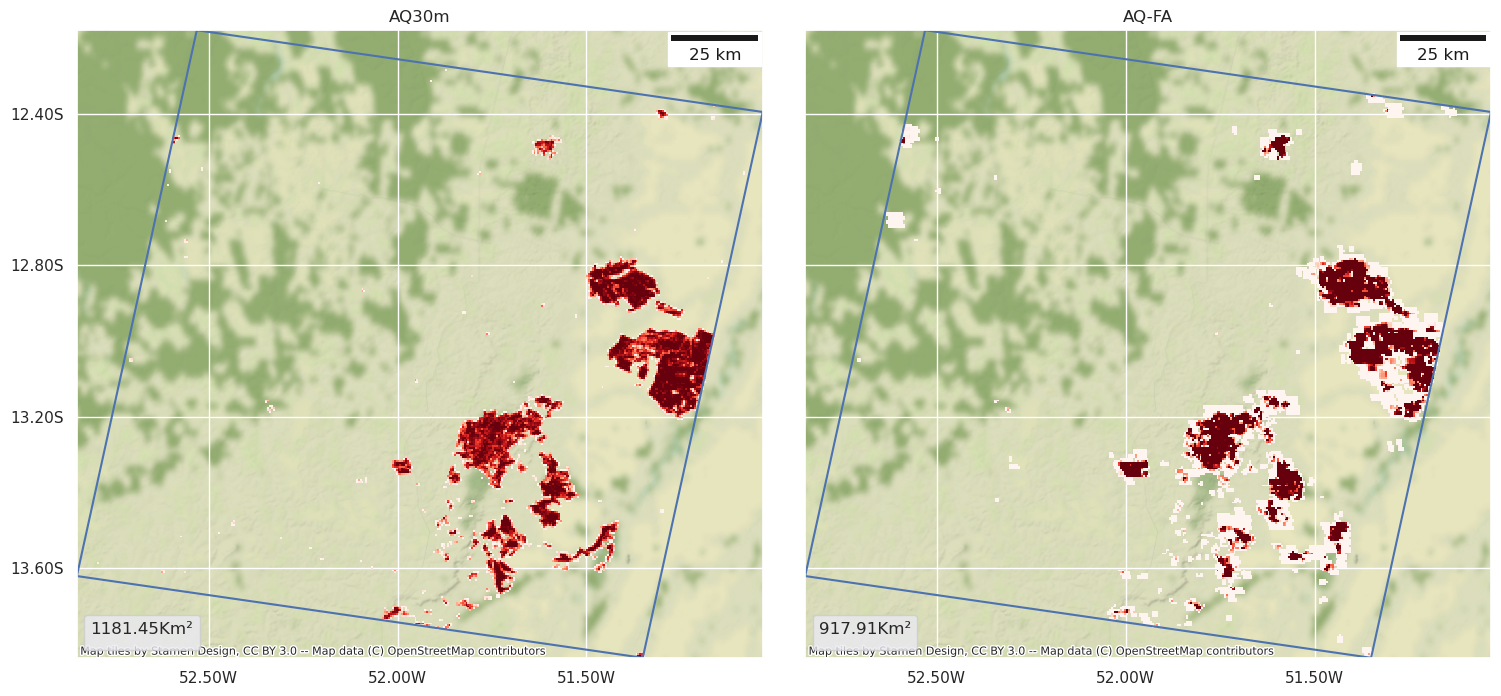

In [15]:
n = validate_plot(file='aq30m/LS8_AQM_224_069_20210910_0109.zip', quadrat_width=0.005)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


min_range: 3.5 max_range: 8.75
{'TP': 343.75085334815464, 'FP': 351.25174910644637, 'FN': 506.4125482952719, 'TN': 88785.58484925012, 'ACC': 0.9904690199984252, 'CE': 0.5053963076769786, 'OE': 0.5956649596022838, 'B': 0.817492967953115, 'DC': 0.4449371167065188, 'TPR': 0.4043350403977161, 'TNR': 0.9960594097512214, 'PPV': 0.4946036923230214, 'NPV': 0.9943285785618545, 'CSI': 0.28612162343183356}


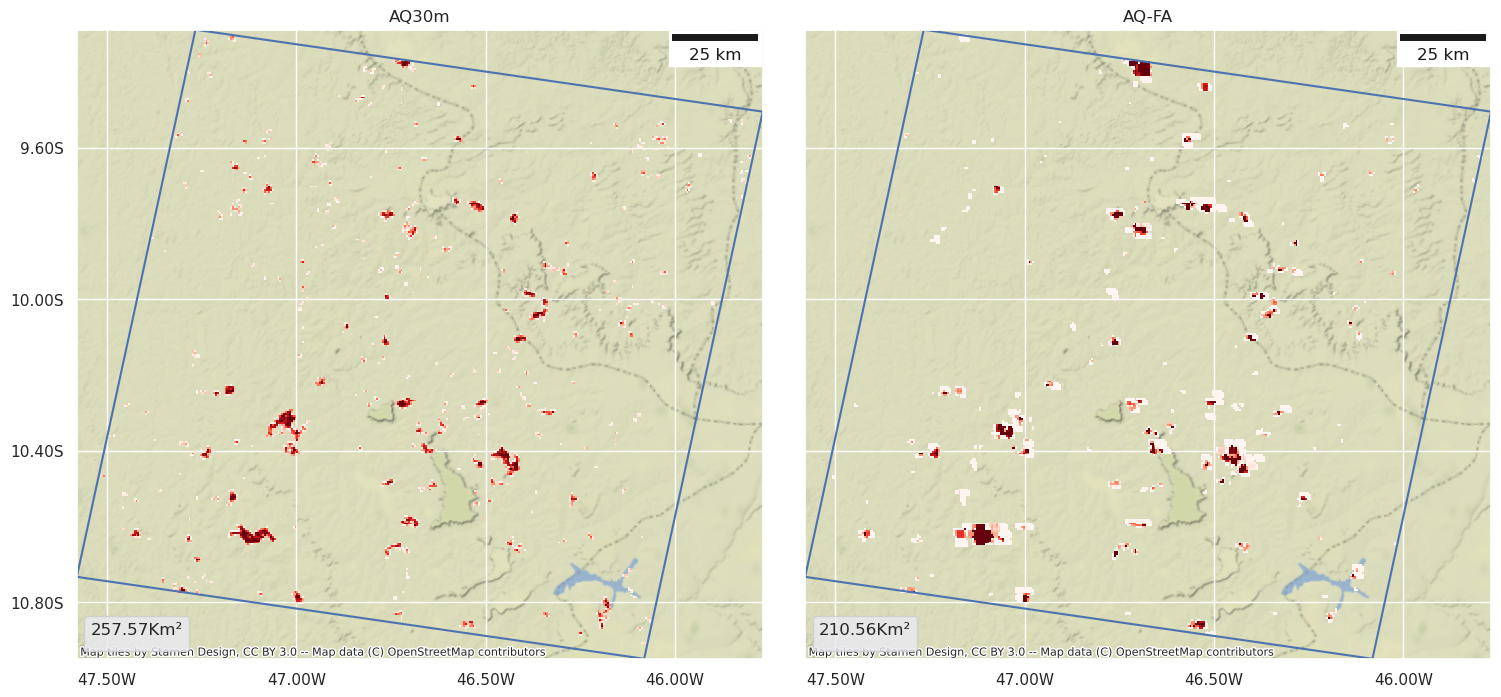

In [46]:
n = validate_plot(file='aq30m/LS8_AQM_221_067_20210719_0107.zip', quadrat_width=0.005)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


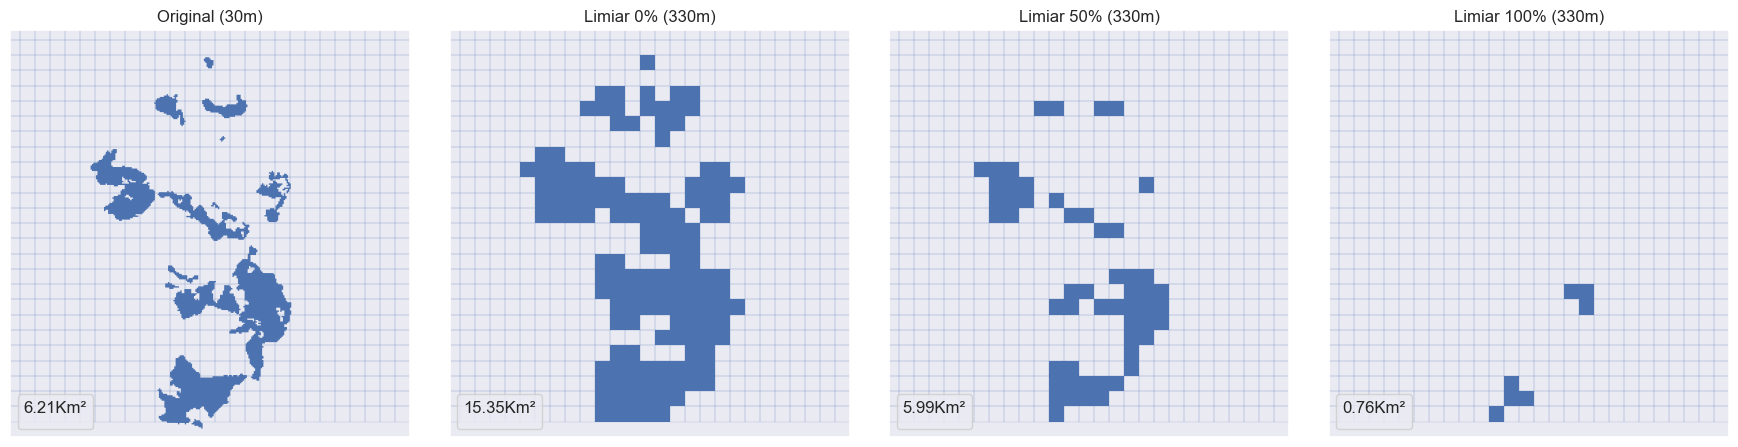

In [152]:
# cmap1 = copy.copy(plt.cm.rainbow)
quadrat_width = 0.003
linewidth = 0.1
geometry = box(-47.27, -10.77, -47.19, -10.69)
xmin, ymin, xmax, ymax = geometry.bounds
geod = Geod(ellps="WGS84")

fig, axs = plt.subplots(1, 4, figsize=(18, 5), sharey=True, sharex=True)
fig.tight_layout()

ax1 = axs[0]
aqm30 = gpd.read_file('aq30m/LS8_AQM_221_067_20210820_0107.zip', engine="pyogrio")
aqm30_test = aqm30.cx[xmin:xmax, ymin:ymax]
aqm30_test.plot(ax=ax1, linewidth=0.0)
grid_gdf(aqm30_test, geometry, quadrat_width).boundary.plot(ax=ax1, linewidth=linewidth)
ax1.legend(title = "{:.2f}Km²".format(aqm30_test['km2'].sum()), loc='lower left')
ax1.set_title('Original (30m)')

threshold = [0.0, 0.5, 0.9999]

for i, t in enumerate(threshold):
    ax = axs[i+1]
    test = normalize_gdf(aqm30, geometry, quadrat_width)
    test.loc[test['value'] > t, 'value'] = 1
    test.loc[test['value'] <= t, 'value'] = 0
    plot_burned_gdf(ax, test, simple = True)
    test.boundary.plot(ax=ax, linewidth=linewidth)
    new_resolution = geod.geometry_length(test['geometry'].iloc[0]) / 4
    ax.set_title(f"Limiar {round(t * 100)}% ({round(new_resolution)}m)")

for ax in axs.flat:
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    # cx.add_basemap(ax, crs=aqm30.crs.to_string())

fig.savefig(os.path.join(image_folder, 'diferenca_resoluções.pdf'), bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


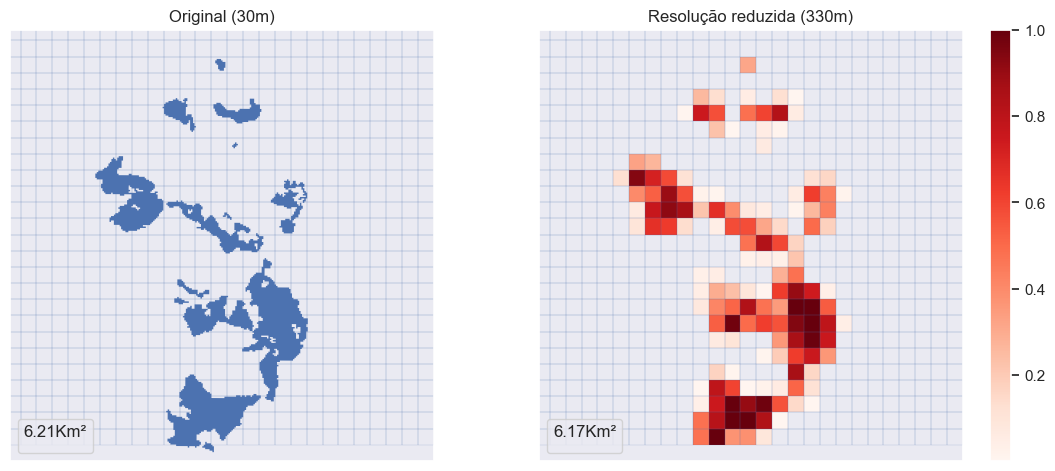

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)
fig.tight_layout()

ax1 = axs[0]
aqm30 = gpd.read_file('aq30m/LS8_AQM_221_067_20210820_0107.zip', engine="pyogrio")
aqm30_test = aqm30.cx[xmin:xmax, ymin:ymax]
aqm30_test.plot(ax=ax1, linewidth=0.0)
grid_gdf(aqm30_test, geometry, quadrat_width).boundary.plot(ax=ax1, linewidth=linewidth)
ax1.legend(title = "{:.2f}Km²".format(aqm30_test['km2'].sum()), loc='lower left')
ax1.set_title('Original (30m)')

ax2 = axs[1]
test = normalize_gdf(aqm30, geometry, quadrat_width)
plot_burned_gdf(ax2, test)
test.boundary.plot(ax=ax2, linewidth=linewidth)
new_resolution = geod.geometry_length(test['geometry'].iloc[0]) / 4
ax2.set_title(f'Resolução reduzida ({round(new_resolution)}m)')

for ax in axs.flat:
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    # cx.add_basemap(ax, crs=aqm30.crs.to_string())

fig.savefig(os.path.join(image_folder, 'resolução_continua.pdf'), bbox_inches="tight")